# Phase 1: Baseline Models

**Trial 1: ResNet50**
- Pre-trained on ImageNet
- Fast to train (freeze backbone)

**Trial 2-4: EfficientNet**
- B0, B1, B3
- Better accuracy/compute tradeoff
- Compound scaling strategy

**Trial 5-7: Newer Architectures**
- ConvNeXt-Tiny (Modern CNN)
- ViT-Small (Vision Transformer)
- MobileNetV3 (Lightweight option)

---

## 1. Setup & Configuration

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
from datetime import datetime
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tqdm.auto import tqdm
import cv2
from PIL import Image

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set random seeds
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB')

Using device: cuda
GPU: NVIDIA L4
Memory: 23.80 GB


In [ ]:
CLASS_NAMES = {
    0: 'Groove_billed_Ani', 1: 'Red_winged_Blackbird', 2: 'Rusty_Blackbird',
    3: 'Gray_Catbird', 4: 'Brandt_Cormorant', 5: 'Eastern_Towhee',
    6: 'Indigo_Bunting', 7: 'Brewer_Blackbird', 8: 'Painted_Bunting',
    9: 'Bobolink', 10: 'Lazuli_Bunting', 11: 'Yellow_headed_Blackbird',
    12: 'American_Crow', 13: 'Fish_Crow', 14: 'Brown_Creeper',
    15: 'Yellow_billed_Cuckoo', 16: 'Yellow_breasted_Chat',
    17: 'Black_billed_Cuckoo', 18: 'Gray_crowned_Rosy_Finch', 19: 'Bronzed_Cowbird'
}

NUM_CLASSES = 20

CONFIG = {
    'data_dir': '/content/drive/MyDrive/data',
    'train_csv': '/content/drive/MyDrive/data/train_metadata.csv',
    'val_csv': '/content/drive/MyDrive/data/val_metadata.csv',
    'train_images': '/content/drive/MyDrive/data/train_images',
    'val_images': '/content/drive/MyDrive/data/val_images',
    'test_images': '/content/drive/MyDrive/data/test_images',
    'sample_submission': '/content/drive/MyDrive/data/sample_submission.csv',

    # Training params
    'img_size': 224,
    'batch_size': 32,
    'epochs': 20,  # Start with fewer epochs for baselines
    'lr': 1e-3,  # Higher LR for frozen backbone
    'weight_decay': 1e-4,
    'num_workers': 4,

    # Output
    'checkpoint_dir': '/content/drive/My Drive/ml_results/phase1_checkpoints',
    'results_dir': '/content/drive/My Drive/ml_results/phase1_results',
}

# Create directories
os.makedirs(CONFIG['checkpoint_dir'], exist_ok=True)
os.makedirs(CONFIG['results_dir'], exist_ok=True)

## 2. Data Loading

In [ ]:
# Load metadata
train_df = pd.read_csv(CONFIG['train_csv'])
val_df = pd.read_csv(CONFIG['val_csv'])

print(f"Training samples: {len(train_df):,}")
print(f"Validation samples: {len(val_df):,}")
print("\nClass distribution:")
print(train_df['class_idx'].value_counts().sort_index())

Training samples: 1,082
Validation samples: 103

Class distribution:
class_idx
0     58
1     53
2     57
3     54
4     53
5     54
6     57
7     55
8     52
9     58
10    54
11    54
12    53
13    54
14    52
15    55
16    51
17    55
18    51
19    52
Name: count, dtype: int64


In [ ]:
# Dataset class
class BirdDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, row['path'])

        # Load image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Apply transforms
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, row['class_idx']

In [ ]:
def get_transforms(img_size=224, mode='train'):
    """Simple transforms for baseline models"""
    if mode == 'train':
        return A.Compose([
            A.Resize(img_size, img_size),
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])
    else:
        return A.Compose([
            A.Resize(img_size, img_size),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])

# Create dataloaders
train_dataset = BirdDataset(
    train_df,
    CONFIG['train_images'],
    get_transforms(CONFIG['img_size'], 'train')
)

val_dataset = BirdDataset(
    val_df,
    CONFIG['val_images'],
    get_transforms(CONFIG['img_size'], 'val')
)

train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=CONFIG['num_workers'],
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=True
)

## 3. Models

In [ ]:
def create_model(model_name, num_classes=NUM_CLASSES, pretrained=True, freeze_backbone=False):
    """
    Create models using timm library
    """
    # Create model
    model = timm.create_model(
        model_name,
        pretrained=pretrained,
        num_classes=num_classes
    )

    if freeze_backbone:
        # Freeze all parameters
        for param in model.parameters():
            param.requires_grad = False

        # Unfreeze classifier (last layer)
        if hasattr(model, 'fc'):
            for param in model.fc.parameters():
                param.requires_grad = True
        elif hasattr(model, 'classifier'):
            for param in model.classifier.parameters():
                param.requires_grad = True
        elif hasattr(model, 'head'):
            for param in model.head.parameters():
                param.requires_grad = True

    return model

def count_parameters(model):
    """Count trainable parameters"""
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

# Test model creation
test_model = create_model('resnet50', freeze_backbone=True)
total, trainable = count_parameters(test_model)
print(f"Test model (ResNet50):")
print(f"  Total parameters: {total:,}")
print(f"  Trainable parameters: {trainable:,}")
print(f"  Frozen: {total - trainable:,}")
del test_model

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Test model (ResNet50):
  Total parameters: 23,549,012
  Trainable parameters: 40,980
  Frozen: 23,508,032


## 4. Training Functions

In [ ]:
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc='Training', leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100.*correct/total:.2f}%'})

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate(model, loader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        pbar = tqdm(loader, desc='Validation', leave=False)
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100.*correct/total:.2f}%'})

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels

In [ ]:
def train_model(model, train_loader, val_loader, model_name,
               epochs=20, lr=1e-3, weight_decay=1e-4):
    """
    Complete training loop
    """
    print(f"\n{'='*60}")
    print(f"Training: {model_name}")
    print(f"{'='*60}")

    # Count parameters
    total_params, trainable_params = count_parameters(model)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Frozen parameters: {total_params - trainable_params:,}")

    # Setup
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=lr,
        weight_decay=weight_decay
    )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    # Training history
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'epoch_times': []
    }

    best_val_acc = 0.0
    start_time = time.time()

    # Training loop
    for epoch in range(epochs):
        epoch_start = time.time()

        print(f"\nEpoch {epoch+1}/{epochs}")

        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

        # Validate
        val_loss, val_acc, val_preds, val_labels = validate(model, val_loader, criterion, device)

        # Update scheduler
        scheduler.step()

        # Track time
        epoch_time = time.time() - epoch_start
        history['epoch_times'].append(epoch_time)

        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Print progress
        print(f"Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
        print(f"Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
        print(f"Time: {epoch_time:.2f}s | LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            checkpoint_path = os.path.join(CONFIG['checkpoint_dir'], f'{model_name}_best.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'val_loss': val_loss,
            }, checkpoint_path)
            print(f"✓ Best model saved: {val_acc:.4f}")

    total_time = time.time() - start_time

    print(f"\n{'='*60}")
    print(f"Training Complete!")
    print(f"Best Val Accuracy: {best_val_acc:.4f}")
    print(f"Total Time: {total_time/60:.2f} minutes")
    print(f"Avg Time/Epoch: {np.mean(history['epoch_times']):.2f}s")
    print(f"{'='*60}")

    return history, best_val_acc, total_time

## 5. Define Trials

In [ ]:
BASELINE_MODELS = [
    # Trial 1: ResNet50 - The Classic
    {
        'name': 'resnet50_frozen',
        'model_type': 'resnet50',
        'freeze': True,
        'lr': 1e-3,
        'description': 'ResNet50 with frozen backbone (only train classifier)'
    },
    {
        'name': 'resnet50_finetuned',
        'model_type': 'resnet50',
        'freeze': False,
        'lr': 1e-4,
        'description': 'ResNet50 full fine-tuning'
    },

    # Trials 2-4: EfficientNet
    {
        'name': 'efficientnet_b0',
        'model_type': 'efficientnet_b0',
        'freeze': False,
        'lr': 1e-4,
        'description': 'EfficientNet-B0 (baseline efficiency)'
    },
    {
        'name': 'efficientnet_b1',
        'model_type': 'efficientnet_b1',
        'freeze': False,
        'lr': 1e-4,
        'description': 'EfficientNet-B1 (scaled up)'
    },
    {
        'name': 'efficientnet_b3',
        'model_type': 'efficientnet_b3',
        'freeze': False,
        'lr': 1e-4,
        'description': 'EfficientNet-B3 (good balance)'
    },

    # Trials 5-7: Newer Architectures
    {
        'name': 'convnext_tiny',
        'model_type': 'convnext_tiny',
        'freeze': False,
        'lr': 1e-4,
        'description': 'ConvNeXt-Tiny (modern CNN)'
    },
    {
        'name': 'vit_small_patch16_224',
        'model_type': 'vit_small_patch16_224',
        'freeze': False,
        'lr': 5e-5,
        'description': 'Vision Transformer Small'
    },
    {
        'name': 'mobilenetv3_large_100',
        'model_type': 'mobilenetv3_large_100',
        'freeze': False,
        'lr': 1e-4,
        'description': 'MobileNetV3 (lightweight)'
    },
]

print(f"Phase 1: {len(BASELINE_MODELS)} baseline models to train")
for i, config in enumerate(BASELINE_MODELS, 1):
    print(f"  {i}. {config['name']}: {config['description']}")

Phase 1: 8 baseline models to train
  1. resnet50_frozen: ResNet50 with frozen backbone (only train classifier)
  2. resnet50_finetuned: ResNet50 full fine-tuning
  3. efficientnet_b0: EfficientNet-B0 (baseline efficiency)
  4. efficientnet_b1: EfficientNet-B1 (scaled up)
  5. efficientnet_b3: EfficientNet-B3 (good balance)
  6. convnext_tiny: ConvNeXt-Tiny (modern CNN)
  7. vit_small_patch16_224: Vision Transformer Small
  8. mobilenetv3_large_100: MobileNetV3 (lightweight)


In [ ]:
# Train all models
results = {}

for trial_config in BASELINE_MODELS:
    model_name = trial_config['name']

    print(f"\n\n{'#'*80}")
    print(f"TRIAL: {model_name}")
    print(f"Description: {trial_config['description']}")
    print(f"{'#'*80}")

    # Create model
    model = create_model(
        trial_config['model_type'],
        num_classes=NUM_CLASSES,
        pretrained=True,
        freeze_backbone=trial_config['freeze']
    )

    # Train
    history, best_acc, total_time = train_model(
        model,
        train_loader,
        val_loader,
        model_name,
        epochs=CONFIG['epochs'],
        lr=trial_config['lr'],
        weight_decay=CONFIG['weight_decay']
    )

    # Save results
    results[model_name] = {
        'config': trial_config,
        'history': history,
        'best_val_acc': best_acc,
        'total_time': total_time,
        'avg_epoch_time': np.mean(history['epoch_times']),
        'final_train_acc': history['train_acc'][-1],
        'final_val_acc': history['val_acc'][-1],
    }

    # Clear memory
    del model
    torch.cuda.empty_cache()

    print(f"\n✓ {model_name} complete!\n")

print(f"\n\n{'='*80}")
print("PHASE 1 COMPLETE - ALL BASELINES TRAINED")
print(f"{'='*80}")



################################################################################
TRIAL: resnet50_frozen
Description: ResNet50 with frozen backbone (only train classifier)
################################################################################

Training: resnet50_frozen
Total parameters: 23,549,012
Trainable parameters: 40,980
Frozen parameters: 23,508,032

Epoch 1/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 2.8809, Acc: 0.1959
Val   - Loss: 2.7198, Acc: 0.3981
Time: 163.39s | LR: 0.000994
✓ Best model saved: 0.3981

Epoch 2/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 2.5400, Acc: 0.4908
Val   - Loss: 2.4853, Acc: 0.4854
Time: 5.98s | LR: 0.000976
✓ Best model saved: 0.4854

Epoch 3/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 2.2737, Acc: 0.6377
Val   - Loss: 2.3033, Acc: 0.5534
Time: 6.07s | LR: 0.000946
✓ Best model saved: 0.5534

Epoch 4/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 2.0549, Acc: 0.6941
Val   - Loss: 2.1309, Acc: 0.5437
Time: 105.71s | LR: 0.000905

Epoch 5/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 1.8916, Acc: 0.7079
Val   - Loss: 2.0107, Acc: 0.6019
Time: 5.71s | LR: 0.000854
✓ Best model saved: 0.6019

Epoch 6/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 1.7328, Acc: 0.7449
Val   - Loss: 1.8992, Acc: 0.6019
Time: 5.93s | LR: 0.000794

Epoch 7/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 1.6217, Acc: 0.7523
Val   - Loss: 1.8248, Acc: 0.5728
Time: 5.85s | LR: 0.000727

Epoch 8/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 1.5185, Acc: 0.7680
Val   - Loss: 1.7771, Acc: 0.6505
Time: 6.11s | LR: 0.000655
✓ Best model saved: 0.6505

Epoch 9/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 1.4418, Acc: 0.7699
Val   - Loss: 1.7190, Acc: 0.6117
Time: 5.66s | LR: 0.000578

Epoch 10/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 1.3613, Acc: 0.7921
Val   - Loss: 1.6705, Acc: 0.6311
Time: 5.92s | LR: 0.000500

Epoch 11/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 1.3156, Acc: 0.8013
Val   - Loss: 1.6467, Acc: 0.6505
Time: 5.75s | LR: 0.000422

Epoch 12/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 1.2992, Acc: 0.8078
Val   - Loss: 1.6347, Acc: 0.6408
Time: 5.77s | LR: 0.000345

Epoch 13/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 1.2515, Acc: 0.8013
Val   - Loss: 1.5923, Acc: 0.6505
Time: 5.77s | LR: 0.000273

Epoch 14/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 1.2473, Acc: 0.8133
Val   - Loss: 1.5904, Acc: 0.6311
Time: 205.42s | LR: 0.000206

Epoch 15/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 1.2085, Acc: 0.8152
Val   - Loss: 1.5564, Acc: 0.6505
Time: 5.82s | LR: 0.000146

Epoch 16/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 1.1831, Acc: 0.8235
Val   - Loss: 1.5323, Acc: 0.6408
Time: 5.77s | LR: 0.000095

Epoch 17/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 1.1921, Acc: 0.8170
Val   - Loss: 1.5535, Acc: 0.6505
Time: 5.92s | LR: 0.000054

Epoch 18/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 1.1924, Acc: 0.8179
Val   - Loss: 1.5602, Acc: 0.6408
Time: 5.75s | LR: 0.000024

Epoch 19/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ac8db536ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7ac8db536ac0>if w.is_alive():

Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
       self._shutdown_workers() 
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      ^if w.is_alive():^
^ ^ ^^  ^ ^ ^ ^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ ^ ^ 
   File "/usr/lib/p

Train - Loss: 1.1823, Acc: 0.8272
Val   - Loss: 1.5655, Acc: 0.6408
Time: 186.75s | LR: 0.000006

Epoch 20/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 1.1736, Acc: 0.8299
Val   - Loss: 1.5610, Acc: 0.6505
Time: 5.69s | LR: 0.000000

Training Complete!
Best Val Accuracy: 0.6505
Total Time: 15.73 minutes
Avg Time/Epoch: 37.74s

✓ resnet50_frozen complete!



################################################################################
TRIAL: resnet50_finetuned
Description: ResNet50 full fine-tuning
################################################################################

Training: resnet50_finetuned
Total parameters: 23,549,012
Trainable parameters: 23,549,012
Frozen parameters: 0

Epoch 1/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 2.9799, Acc: 0.0887
Val   - Loss: 2.9496, Acc: 0.2039
Time: 47.49s | LR: 0.000099
✓ Best model saved: 0.2039

Epoch 2/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ac8db536ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ac8db536ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Train - Loss: 2.9006, Acc: 0.3087
Val   - Loss: 2.8790, Acc: 0.3204
Time: 8.27s | LR: 0.000098
✓ Best model saved: 0.3204

Epoch 3/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 2.7819, Acc: 0.5231
Val   - Loss: 2.7302, Acc: 0.4951
Time: 8.18s | LR: 0.000095
✓ Best model saved: 0.4951

Epoch 4/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 2.5722, Acc: 0.6645
Val   - Loss: 2.4208, Acc: 0.6505
Time: 7.24s | LR: 0.000090
✓ Best model saved: 0.6505

Epoch 5/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 2.2246, Acc: 0.7181
Val   - Loss: 1.9141, Acc: 0.7670
Time: 8.10s | LR: 0.000085
✓ Best model saved: 0.7670

Epoch 6/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 1.7630, Acc: 0.7911
Val   - Loss: 1.4433, Acc: 0.7767
Time: 8.14s | LR: 0.000079
✓ Best model saved: 0.7767

Epoch 7/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 1.3541, Acc: 0.8133
Val   - Loss: 1.1016, Acc: 0.8058
Time: 7.22s | LR: 0.000073
✓ Best model saved: 0.8058

Epoch 8/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 1.0763, Acc: 0.8309
Val   - Loss: 0.9077, Acc: 0.8350
Time: 8.10s | LR: 0.000065
✓ Best model saved: 0.8350

Epoch 9/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.8517, Acc: 0.8614
Val   - Loss: 0.7639, Acc: 0.8447
Time: 7.19s | LR: 0.000058
✓ Best model saved: 0.8447

Epoch 10/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.7100, Acc: 0.8771
Val   - Loss: 0.6802, Acc: 0.8641
Time: 8.10s | LR: 0.000050
✓ Best model saved: 0.8641

Epoch 11/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.6208, Acc: 0.8854
Val   - Loss: 0.6233, Acc: 0.8738
Time: 86.85s | LR: 0.000042
✓ Best model saved: 0.8738

Epoch 12/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.5439, Acc: 0.9048
Val   - Loss: 0.5847, Acc: 0.8641
Time: 8.17s | LR: 0.000035

Epoch 13/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.4928, Acc: 0.9104
Val   - Loss: 0.5468, Acc: 0.8738
Time: 12.06s | LR: 0.000027

Epoch 14/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.4519, Acc: 0.9131
Val   - Loss: 0.5181, Acc: 0.8738
Time: 87.15s | LR: 0.000021

Epoch 15/20


Training:   0%|          | 0/34 [00:39<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.4301, Acc: 0.9205
Val   - Loss: 0.5251, Acc: 0.8544
Time: 46.65s | LR: 0.000015

Epoch 16/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.4172, Acc: 0.9270
Val   - Loss: 0.4921, Acc: 0.8641
Time: 7.27s | LR: 0.000010

Epoch 17/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.3934, Acc: 0.9390
Val   - Loss: 0.5054, Acc: 0.8641
Time: 7.18s | LR: 0.000005

Epoch 18/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.4146, Acc: 0.9224
Val   - Loss: 0.4977, Acc: 0.8641
Time: 7.16s | LR: 0.000002

Epoch 19/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Train - Loss: 0.4519, Acc: 0.9131
Val   - Loss: 0.5181, Acc: 0.8738
Time: 87.15s | LR: 0.000021

Epoch 15/20


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ac8db536ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ac8db536ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.3887, Acc: 0.9233
Val   - Loss: 0.4843, Acc: 0.8641
Time: 7.74s | LR: 0.000001

Epoch 20/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.3957, Acc: 0.9279
Val   - Loss: 0.5053, Acc: 0.8738
Time: 7.30s | LR: 0.000000

Training Complete!
Best Val Accuracy: 0.8738
Total Time: 11.02 minutes
Avg Time/Epoch: 19.78s

✓ resnet50_finetuned complete!



################################################################################
TRIAL: efficientnet_b0
Description: EfficientNet-B0 (baseline efficiency)
################################################################################


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]


Training: efficientnet_b0
Total parameters: 4,033,168
Trainable parameters: 4,033,168
Frozen parameters: 0

Epoch 1/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 3.3839, Acc: 0.1155
Val   - Loss: 2.5010, Acc: 0.3107
Time: 6.09s | LR: 0.000099
✓ Best model saved: 0.3107

Epoch 2/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 1.4699, Acc: 0.5823
Val   - Loss: 1.6762, Acc: 0.5243
Time: 5.98s | LR: 0.000098
✓ Best model saved: 0.5243

Epoch 3/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.7131, Acc: 0.7976
Val   - Loss: 1.3253, Acc: 0.5825
Time: 6.02s | LR: 0.000095
✓ Best model saved: 0.5825

Epoch 4/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.4154, Acc: 0.9122
Val   - Loss: 1.2192, Acc: 0.6311
Time: 6.01s | LR: 0.000090
✓ Best model saved: 0.6311

Epoch 5/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.2611, Acc: 0.9603
Val   - Loss: 1.0663, Acc: 0.6505
Time: 6.30s | LR: 0.000085
✓ Best model saved: 0.6505

Epoch 6/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.1915, Acc: 0.9667
Val   - Loss: 1.0393, Acc: 0.6699
Time: 6.03s | LR: 0.000079
✓ Best model saved: 0.6699

Epoch 7/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.1380, Acc: 0.9750
Val   - Loss: 1.0400, Acc: 0.6699
Time: 5.86s | LR: 0.000073

Epoch 8/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ac8db536ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ac8db536ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Train - Loss: 0.1126, Acc: 0.9824
Val   - Loss: 1.0062, Acc: 0.6796
Time: 6.51s | LR: 0.000065
✓ Best model saved: 0.6796

Epoch 9/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0987, Acc: 0.9871
Val   - Loss: 0.9229, Acc: 0.6796
Time: 6.01s | LR: 0.000058

Epoch 10/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0770, Acc: 0.9926
Val   - Loss: 0.9065, Acc: 0.7184
Time: 6.10s | LR: 0.000050
✓ Best model saved: 0.7184

Epoch 11/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0645, Acc: 0.9898
Val   - Loss: 0.9095, Acc: 0.7184
Time: 6.08s | LR: 0.000042

Epoch 12/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0541, Acc: 0.9945
Val   - Loss: 0.9201, Acc: 0.7087
Time: 5.92s | LR: 0.000035

Epoch 13/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0481, Acc: 0.9945
Val   - Loss: 0.8955, Acc: 0.7184
Time: 6.04s | LR: 0.000027

Epoch 14/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0513, Acc: 0.9954
Val   - Loss: 0.9233, Acc: 0.6893
Time: 6.01s | LR: 0.000021

Epoch 15/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0522, Acc: 0.9963
Val   - Loss: 0.8904, Acc: 0.7282
Time: 165.60s | LR: 0.000015
✓ Best model saved: 0.7282

Epoch 16/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0479, Acc: 0.9972
Val   - Loss: 0.9093, Acc: 0.7087
Time: 6.03s | LR: 0.000010

Epoch 17/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0442, Acc: 0.9945
Val   - Loss: 0.8992, Acc: 0.7087
Time: 6.50s | LR: 0.000005

Epoch 18/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0446, Acc: 0.9954
Val   - Loss: 0.9241, Acc: 0.6990
Time: 105.51s | LR: 0.000002

Epoch 19/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0384, Acc: 0.9963
Val   - Loss: 0.8864, Acc: 0.7379
Time: 6.07s | LR: 0.000001
✓ Best model saved: 0.7379

Epoch 20/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0364, Acc: 0.9972
Val   - Loss: 0.9049, Acc: 0.6990
Time: 5.90s | LR: 0.000000

Training Complete!
Best Val Accuracy: 0.7379
Total Time: 11.12 minutes
Avg Time/Epoch: 19.03s

✓ efficientnet_b0 complete!



################################################################################
TRIAL: efficientnet_b1
Description: EfficientNet-B1 (scaled up)
################################################################################


model.safetensors:   0%|          | 0.00/31.5M [00:00<?, ?B/s]


Training: efficientnet_b1
Total parameters: 6,538,804
Trainable parameters: 6,538,804
Frozen parameters: 0

Epoch 1/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 2.7333, Acc: 0.3170
Val   - Loss: 1.1278, Acc: 0.6408
Time: 6.61s | LR: 0.000099
✓ Best model saved: 0.6408

Epoch 2/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.5401, Acc: 0.8336
Val   - Loss: 0.8786, Acc: 0.7087
Time: 6.37s | LR: 0.000098
✓ Best model saved: 0.7087

Epoch 3/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.2471, Acc: 0.9187
Val   - Loss: 0.6368, Acc: 0.7379
Time: 6.52s | LR: 0.000095
✓ Best model saved: 0.7379

Epoch 4/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.1014, Acc: 0.9723
Val   - Loss: 0.5994, Acc: 0.8155
Time: 46.41s | LR: 0.000090
✓ Best model saved: 0.8155

Epoch 5/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0743, Acc: 0.9824
Val   - Loss: 0.6391, Acc: 0.7961
Time: 6.69s | LR: 0.000085

Epoch 6/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0596, Acc: 0.9861
Val   - Loss: 0.5542, Acc: 0.8155
Time: 65.99s | LR: 0.000079

Epoch 7/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0355, Acc: 0.9945
Val   - Loss: 0.5623, Acc: 0.8252
Time: 6.47s | LR: 0.000073
✓ Best model saved: 0.8252

Epoch 8/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ac8db536ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ac8db536ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0269, Acc: 0.9954
Val   - Loss: 0.6377, Acc: 0.7961
Time: 6.69s | LR: 0.000065

Epoch 9/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0267, Acc: 0.9935
Val   - Loss: 0.7179, Acc: 0.7476
Time: 7.95s | LR: 0.000058

Epoch 10/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0194, Acc: 0.9963
Val   - Loss: 0.6778, Acc: 0.7961
Time: 86.42s | LR: 0.000050

Epoch 11/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0146, Acc: 0.9991
Val   - Loss: 0.6556, Acc: 0.7864
Time: 6.53s | LR: 0.000042

Epoch 12/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0101, Acc: 0.9991
Val   - Loss: 0.5924, Acc: 0.7864
Time: 6.39s | LR: 0.000035

Epoch 13/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0064, Acc: 1.0000
Val   - Loss: 0.6004, Acc: 0.7767
Time: 86.63s | LR: 0.000027

Epoch 14/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0078, Acc: 1.0000
Val   - Loss: 0.5723, Acc: 0.7864
Time: 6.44s | LR: 0.000021

Epoch 15/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ac8db536ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ac8db536ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Train - Loss: 0.0072, Acc: 0.9991
Val   - Loss: 0.5788, Acc: 0.7573
Time: 41.57s | LR: 0.000015

Epoch 16/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0059, Acc: 0.9991
Val   - Loss: 0.5559, Acc: 0.7864
Time: 6.44s | LR: 0.000010

Epoch 17/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0065, Acc: 0.9991
Val   - Loss: 0.6121, Acc: 0.7573
Time: 6.45s | LR: 0.000005

Epoch 18/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0125, Acc: 0.9991
Val   - Loss: 0.5339, Acc: 0.7767
Time: 86.70s | LR: 0.000002

Epoch 19/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0127, Acc: 0.9972
Val   - Loss: 0.5583, Acc: 0.7961
Time: 6.45s | LR: 0.000001

Epoch 20/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0073, Acc: 0.9982
Val   - Loss: 0.5649, Acc: 0.7864
Time: 6.56s | LR: 0.000000

Training Complete!
Best Val Accuracy: 0.8252
Total Time: 9.95 minutes
Avg Time/Epoch: 25.31s

✓ efficientnet_b1 complete!



################################################################################
TRIAL: efficientnet_b3
Description: EfficientNet-B3 (good balance)
################################################################################


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]


Training: efficientnet_b3
Total parameters: 10,726,972
Trainable parameters: 10,726,972
Frozen parameters: 0

Epoch 1/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 3.0440, Acc: 0.1534
Val   - Loss: 2.1361, Acc: 0.3883
Time: 8.54s | LR: 0.000099
✓ Best model saved: 0.3883

Epoch 2/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 1.2981, Acc: 0.6433
Val   - Loss: 1.3032, Acc: 0.5631
Time: 8.24s | LR: 0.000098
✓ Best model saved: 0.5631

Epoch 3/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.5750, Acc: 0.8614
Val   - Loss: 0.9555, Acc: 0.6796
Time: 8.25s | LR: 0.000095
✓ Best model saved: 0.6796

Epoch 4/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.3238, Acc: 0.9362
Val   - Loss: 0.7688, Acc: 0.7573
Time: 28.55s | LR: 0.000090
✓ Best model saved: 0.7573

Epoch 5/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.1897, Acc: 0.9704
Val   - Loss: 0.7088, Acc: 0.7087
Time: 8.24s | LR: 0.000085

Epoch 6/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.1382, Acc: 0.9723
Val   - Loss: 0.6562, Acc: 0.7767
Time: 28.24s | LR: 0.000079
✓ Best model saved: 0.7767

Epoch 7/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0995, Acc: 0.9834
Val   - Loss: 0.6066, Acc: 0.7573
Time: 28.47s | LR: 0.000073

Epoch 8/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0708, Acc: 0.9926
Val   - Loss: 0.5827, Acc: 0.8058
Time: 28.17s | LR: 0.000065
✓ Best model saved: 0.8058

Epoch 9/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ac8db536ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
assert self._parent_pid == os.getpid(), 'can only test a child process'    
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0620, Acc: 0.9898
Val   - Loss: 0.5466, Acc: 0.8155
Time: 8.60s | LR: 0.000058
✓ Best model saved: 0.8155

Epoch 10/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0552, Acc: 0.9908
Val   - Loss: 0.5460, Acc: 0.7864
Time: 8.22s | LR: 0.000050

Epoch 11/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0402, Acc: 0.9954
Val   - Loss: 0.5321, Acc: 0.7670
Time: 28.11s | LR: 0.000042

Epoch 12/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0417, Acc: 0.9917
Val   - Loss: 0.5307, Acc: 0.7864
Time: 28.21s | LR: 0.000035

Epoch 13/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0306, Acc: 0.9972
Val   - Loss: 0.5248, Acc: 0.8155
Time: 28.16s | LR: 0.000027

Epoch 14/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0335, Acc: 0.9935
Val   - Loss: 0.5063, Acc: 0.7961
Time: 28.23s | LR: 0.000021

Epoch 15/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0304, Acc: 0.9982
Val   - Loss: 0.5045, Acc: 0.8350
Time: 28.15s | LR: 0.000015
✓ Best model saved: 0.8350

Epoch 16/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0346, Acc: 0.9963
Val   - Loss: 0.4876, Acc: 0.8252
Time: 28.34s | LR: 0.000010

Epoch 17/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0293, Acc: 0.9972
Val   - Loss: 0.4951, Acc: 0.8058
Time: 28.22s | LR: 0.000005

Epoch 18/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0301, Acc: 0.9972
Val   - Loss: 0.4826, Acc: 0.8252
Time: 28.17s | LR: 0.000002

Epoch 19/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0318, Acc: 0.9963
Val   - Loss: 0.5436, Acc: 0.7767
Time: 28.20s | LR: 0.000001

Epoch 20/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0233, Acc: 0.9991
Val   - Loss: 0.4859, Acc: 0.8155
Time: 28.39s | LR: 0.000000

Training Complete!
Best Val Accuracy: 0.8350
Total Time: 9.01 minutes
Avg Time/Epoch: 22.29s

✓ efficientnet_b3 complete!



################################################################################
TRIAL: convnext_tiny
Description: ConvNeXt-Tiny (modern CNN)
################################################################################


model.safetensors:   0%|          | 0.00/114M [00:20<?, ?B/s]


Training: convnext_tiny
Total parameters: 27,835,508
Trainable parameters: 27,835,508
Frozen parameters: 0

Epoch 1/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 1.0204, Acc: 0.7126
Val   - Loss: 0.4777, Acc: 0.8155
Time: 22.63s | LR: 0.000099
✓ Best model saved: 0.8155

Epoch 2/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.3075, Acc: 0.8909
Val   - Loss: 0.4272, Acc: 0.8447
Time: 13.29s | LR: 0.000098
✓ Best model saved: 0.8447

Epoch 3/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.1295, Acc: 0.9547
Val   - Loss: 0.2558, Acc: 0.9223
Time: 11.96s | LR: 0.000095
✓ Best model saved: 0.9223

Epoch 4/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0401, Acc: 0.9880
Val   - Loss: 0.3028, Acc: 0.9029
Time: 11.99s | LR: 0.000090

Epoch 5/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0624, Acc: 0.9787
Val   - Loss: 0.3427, Acc: 0.8932
Time: 12.01s | LR: 0.000085

Epoch 6/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0311, Acc: 0.9926
Val   - Loss: 0.3274, Acc: 0.8932
Time: 131.81s | LR: 0.000079

Epoch 7/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0230, Acc: 0.9935
Val   - Loss: 0.3776, Acc: 0.8835
Time: 12.01s | LR: 0.000073

Epoch 8/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0284, Acc: 0.9908
Val   - Loss: 0.4849, Acc: 0.8447
Time: 11.98s | LR: 0.000065

Epoch 9/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0162, Acc: 0.9954
Val   - Loss: 0.3524, Acc: 0.8835
Time: 11.94s | LR: 0.000058

Epoch 10/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0215, Acc: 0.9935
Val   - Loss: 0.3394, Acc: 0.8738
Time: 171.88s | LR: 0.000050

Epoch 11/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0071, Acc: 0.9982
Val   - Loss: 0.3351, Acc: 0.8835
Time: 12.00s | LR: 0.000042

Epoch 12/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0034, Acc: 0.9991
Val   - Loss: 0.3064, Acc: 0.9029
Time: 12.02s | LR: 0.000035

Epoch 13/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0017, Acc: 1.0000
Val   - Loss: 0.2931, Acc: 0.9029
Time: 11.92s | LR: 0.000027

Epoch 14/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0022, Acc: 0.9991
Val   - Loss: 0.3950, Acc: 0.8932
Time: 11.75s | LR: 0.000021

Epoch 15/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0010, Acc: 1.0000
Val   - Loss: 0.3311, Acc: 0.9029
Time: 171.89s | LR: 0.000015

Epoch 16/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0022, Acc: 1.0000
Val   - Loss: 0.2888, Acc: 0.9126
Time: 12.05s | LR: 0.000010

Epoch 17/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0009, Acc: 1.0000
Val   - Loss: 0.2919, Acc: 0.9126
Time: 12.02s | LR: 0.000005

Epoch 18/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0018, Acc: 0.9991
Val   - Loss: 0.2873, Acc: 0.9223
Time: 11.94s | LR: 0.000002

Epoch 19/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ac8db536ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ac8db536ac0>    
self._shutdown_workers()Exception ignored in: 
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ac8db536ac0>Traceback (most recent call last):

    Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
if w.is_alive():    
     self._shutdown_workers()  
self._shutdown_workers()
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637,

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0005, Acc: 1.0000
Val   - Loss: 0.2875, Acc: 0.9223
Time: 12.52s | LR: 0.000001

Epoch 20/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0007, Acc: 1.0000
Val   - Loss: 0.2872, Acc: 0.9223
Time: 11.77s | LR: 0.000000

Training Complete!
Best Val Accuracy: 0.9223
Total Time: 12.89 minutes
Avg Time/Epoch: 34.57s

✓ convnext_tiny complete!



################################################################################
TRIAL: vit_small_patch16_224
Description: Vision Transformer Small
################################################################################


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]


Training: vit_small_patch16_224
Total parameters: 21,673,364
Trainable parameters: 21,673,364
Frozen parameters: 0

Epoch 1/20


Training:   0%|          | 0/34 [01:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 1.9429, Acc: 0.4926
Val   - Loss: 0.9095, Acc: 0.8058
Time: 67.22s | LR: 0.000050
✓ Best model saved: 0.8058

Epoch 2/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.4764, Acc: 0.9020
Val   - Loss: 0.4780, Acc: 0.8544
Time: 7.56s | LR: 0.000049
✓ Best model saved: 0.8544

Epoch 3/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.2017, Acc: 0.9630
Val   - Loss: 0.3626, Acc: 0.9029
Time: 68.25s | LR: 0.000047
✓ Best model saved: 0.9029

Epoch 4/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.1123, Acc: 0.9824
Val   - Loss: 0.3469, Acc: 0.9029
Time: 8.32s | LR: 0.000045

Epoch 5/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0810, Acc: 0.9889
Val   - Loss: 0.3139, Acc: 0.9223
Time: 12.00s | LR: 0.000043
✓ Best model saved: 0.9223

Epoch 6/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ac8db536ac0>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ac8db536ac0>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

    Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
       if w.is_alive():
         ^ ^ ^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^^assert self._parent_pid == os.getpid(), 'can only test a child process'^

  File "/usr/lib/python

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0466, Acc: 0.9963
Val   - Loss: 0.3313, Acc: 0.9029
Time: 7.97s | LR: 0.000040

Epoch 7/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0347, Acc: 0.9963
Val   - Loss: 0.3470, Acc: 0.8932
Time: 12.47s | LR: 0.000036

Epoch 8/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0302, Acc: 0.9982
Val   - Loss: 0.2926, Acc: 0.9126
Time: 7.50s | LR: 0.000033

Epoch 9/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0220, Acc: 0.9982
Val   - Loss: 0.3355, Acc: 0.9029
Time: 8.28s | LR: 0.000029

Epoch 10/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ac8db536ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ac8db536ac0>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
        if w.is_alive():
assert self._parent_pid == os.getpid(), 'can only test a child process' 
           ^ ^^ ^ ^^ ^^^ ^ ^^^^
^  File "/

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ac8db536ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
     Exception ignored in:   ^^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7ac8db536ac0>^
^^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^    ^self._shutdown_workers()
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

      File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():    
  assert self._parent_pid == os.getpid(), 'can only test a child process'
          ^ ^ ^ ^ ^ ^ ^^^^^^^^^^^^^
  Fil

Train - Loss: 0.0183, Acc: 0.9982
Val   - Loss: 0.2981, Acc: 0.9223
Time: 9.51s | LR: 0.000025

Epoch 11/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0252, Acc: 0.9954
Val   - Loss: 0.2809, Acc: 0.9223
Time: 7.68s | LR: 0.000021

Epoch 12/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0180, Acc: 0.9963
Val   - Loss: 0.3132, Acc: 0.8835
Time: 7.84s | LR: 0.000017

Epoch 13/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0136, Acc: 1.0000
Val   - Loss: 0.3157, Acc: 0.8932
Time: 7.73s | LR: 0.000014

Epoch 14/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ac8db536ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()Exception ignored in: 
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ac8db536ac0>
    Traceback (most recent call last):
if w.is_alive():  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

      self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
       if w.is_alive():Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ac8db536ac0>^
 ^Traceback (most recent call last):
 ^   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py",

Train - Loss: 0.0136, Acc: 0.9982
Val   - Loss: 0.2985, Acc: 0.9029
Time: 8.41s | LR: 0.000010

Epoch 15/20


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ac8db536ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ac8db536ac0>    
if w.is_alive():Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
       self._shutdown_workers() 
 Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
 <function _MultiProcessingDataLoaderIter.__del__ at 0x7ac8db536ac0>     
if w.is_alive():Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 

Training:   0%|          | 0/34 [00:00<?, ?it/s]

 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive

    ^AssertionError^assert self._parent_pid == os.getpid(), 'can only test a child process': ^
can only test a child process^ 
  ^  ^^  ^ ^ ^  ^^^^^^^
^AssertionError^^: can only test a child process^
^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0119, Acc: 1.0000
Val   - Loss: 0.2928, Acc: 0.9029
Time: 8.69s | LR: 0.000007

Epoch 16/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0106, Acc: 1.0000
Val   - Loss: 0.2936, Acc: 0.9029
Time: 7.72s | LR: 0.000005

Epoch 17/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0093, Acc: 1.0000
Val   - Loss: 0.2896, Acc: 0.9029
Time: 7.72s | LR: 0.000003

Epoch 18/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ac8db536ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ac8db536ac0>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

    Traceback (most recent call last):
if w.is_alive():  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

     self._shutdown_workers()   
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
     if w.is_alive(): 
^^ ^ ^ ^ ^ ^^ ^ ^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^Exception ignored in:     ^^assert self._parent_pid == os.getpid(), 'can only test a child process'<functi

Train - Loss: 0.0106, Acc: 0.9982
Val   - Loss: 0.2883, Acc: 0.8932
Time: 8.16s | LR: 0.000001

Epoch 19/20


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ac8db536ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ac8db536ac0>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

    Traceback (most recent call last):
if w.is_alive():  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

     self._shutdown_workers() 


Training:   0%|          | 0/34 [00:00<?, ?it/s]

   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7ac8db536ac0>     
if w.is_alive(): Traceback (most recent call last):

   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
 ^     ^ self._shutdown_workers()^ 
^   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^ ^     ^if w.is_alive():^^
^^ ^ ^^^ ^^^
^   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^     ^ assert self._parent_pid == os.getpid(), 'can only test a child process'^ 
^^ ^^ 
^   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^     ^ assert self._parent_pid == os.getpid(), 'can only test a child process'Exception ignored in: ^ 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ac8db536ac0>^   
^ Traceback (m

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ac8db536ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ac8db536ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Train - Loss: 0.0134, Acc: 0.9991
Val   - Loss: 0.2882, Acc: 0.8932
Time: 11.10s | LR: 0.000000

Epoch 20/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0109, Acc: 0.9991
Val   - Loss: 0.2884, Acc: 0.8932
Time: 7.72s | LR: 0.000000

Training Complete!
Best Val Accuracy: 0.9223
Total Time: 4.91 minutes
Avg Time/Epoch: 14.59s

✓ vit_small_patch16_224 complete!



################################################################################
TRIAL: mobilenetv3_large_100
Description: MobileNetV3 (lightweight)
################################################################################


model.safetensors:   0%|          | 0.00/22.1M [00:00<?, ?B/s]


Training: mobilenetv3_large_100
Total parameters: 4,227,652
Trainable parameters: 4,227,652
Frozen parameters: 0

Epoch 1/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 3.0315, Acc: 0.1774
Val   - Loss: 2.0388, Acc: 0.3689
Time: 6.20s | LR: 0.000099
✓ Best model saved: 0.3689

Epoch 2/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 1.3636, Acc: 0.5804
Val   - Loss: 1.3387, Acc: 0.5825
Time: 5.91s | LR: 0.000098
✓ Best model saved: 0.5825

Epoch 3/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.7270, Acc: 0.7921
Val   - Loss: 1.1078, Acc: 0.6019
Time: 5.97s | LR: 0.000095
✓ Best model saved: 0.6019

Epoch 4/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.4542, Acc: 0.8752
Val   - Loss: 1.0402, Acc: 0.6408
Time: 6.04s | LR: 0.000090
✓ Best model saved: 0.6408

Epoch 5/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.3006, Acc: 0.9214
Val   - Loss: 0.9104, Acc: 0.6893
Time: 6.01s | LR: 0.000085
✓ Best model saved: 0.6893

Epoch 6/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:05<?, ?it/s]

Train - Loss: 0.2075, Acc: 0.9464
Val   - Loss: 0.9707, Acc: 0.6990
Time: 81.30s | LR: 0.000079
✓ Best model saved: 0.6990

Epoch 7/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.1594, Acc: 0.9695
Val   - Loss: 0.9384, Acc: 0.7184
Time: 6.16s | LR: 0.000073
✓ Best model saved: 0.7184

Epoch 8/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ac8db536ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ac8db536ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Train - Loss: 0.1125, Acc: 0.9824
Val   - Loss: 0.9066, Acc: 0.6990
Time: 6.24s | LR: 0.000065

Epoch 9/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0980, Acc: 0.9815
Val   - Loss: 0.9061, Acc: 0.6990
Time: 7.00s | LR: 0.000058

Epoch 10/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0752, Acc: 0.9898
Val   - Loss: 0.8947, Acc: 0.7184
Time: 6.06s | LR: 0.000050

Epoch 11/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0730, Acc: 0.9880
Val   - Loss: 0.9077, Acc: 0.7282
Time: 5.96s | LR: 0.000042
✓ Best model saved: 0.7282

Epoch 12/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:46<?, ?it/s]

Train - Loss: 0.0573, Acc: 0.9935
Val   - Loss: 0.9087, Acc: 0.7282
Time: 121.30s | LR: 0.000035

Epoch 13/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0486, Acc: 0.9963
Val   - Loss: 0.8815, Acc: 0.7184
Time: 5.92s | LR: 0.000027

Epoch 14/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0501, Acc: 0.9972
Val   - Loss: 0.8814, Acc: 0.7087
Time: 5.91s | LR: 0.000021

Epoch 15/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0453, Acc: 0.9917
Val   - Loss: 0.8887, Acc: 0.7087
Time: 5.89s | LR: 0.000015

Epoch 16/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ac8db536ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ac8db536ac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Train - Loss: 0.0388, Acc: 0.9982
Val   - Loss: 0.9103, Acc: 0.7184
Time: 166.11s | LR: 0.000010

Epoch 17/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0488, Acc: 0.9935
Val   - Loss: 0.8949, Acc: 0.7184
Time: 6.02s | LR: 0.000005

Epoch 18/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0398, Acc: 0.9972
Val   - Loss: 0.8955, Acc: 0.7087
Time: 5.96s | LR: 0.000002

Epoch 19/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0423, Acc: 0.9982
Val   - Loss: 0.9080, Acc: 0.7282
Time: 5.95s | LR: 0.000001

Epoch 20/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train - Loss: 0.0445, Acc: 0.9954
Val   - Loss: 0.8931, Acc: 0.7087
Time: 6.01s | LR: 0.000000

Training Complete!
Best Val Accuracy: 0.7282
Total Time: 9.90 minutes
Avg Time/Epoch: 23.60s

✓ mobilenetv3_large_100 complete!



PHASE 1 COMPLETE - ALL BASELINES TRAINED


## 6. Results Analysis & Comparison

In [ ]:
# Create results comparison table
comparison_data = []

for model_name, result in results.items():
    comparison_data.append({
        'Model': model_name,
        'Best Val Acc': f"{result['best_val_acc']:.4f}",
        'Final Val Acc': f"{result['final_val_acc']:.4f}",
        'Final Train Acc': f"{result['final_train_acc']:.4f}",
        'Total Time (min)': f"{result['total_time']/60:.2f}",
        'Avg Epoch Time (s)': f"{result['avg_epoch_time']:.2f}",
        'Description': result['config']['description']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Best Val Acc', ascending=False)

print("\n" + "="*100)
print("PHASE 1 BASELINE RESULTS")
print("="*100)
display(comparison_df)

# Save results
comparison_df.to_csv(os.path.join(CONFIG['results_dir'], 'phase1_comparison.csv'), index=False)
print("\n✓ Results saved to phase1_results/phase1_comparison.csv")


PHASE 1 BASELINE RESULTS


Model Best Val Acc Final Val Acc Final Train Acc  \
5          convnext_tiny       0.9223        0.9223          1.0000   
6  vit_small_patch16_224       0.9223        0.8932          0.9991   
1     resnet50_finetuned       0.8738        0.8738          0.9279   
4        efficientnet_b3       0.8350        0.8155          0.9991   
3        efficientnet_b1       0.8252        0.7864          0.9982   
2        efficientnet_b0       0.7379        0.6990          0.9972   
7  mobilenetv3_large_100       0.7282        0.7087          0.9954   
0        resnet50_frozen       0.6505        0.6505          0.8299   

  Total Time (min) Avg Epoch Time (s)  \
5            12.89              34.57   
6             4.91              14.59   
1            11.02              19.78   
4             9.01              22.29   
3             9.95              25.31   
2            11.12              19.03   
7             9.90              23.60   
0            15.73              37.74   

                                         Description  
5                         ConvNeXt-Tiny (modern CNN)  
6                           Vision Transformer Small  
1                          ResNet50 full fine-tuning  
4                     EfficientNet-B3 (good balance)  
3                        EfficientNet-B1 (scaled up)  
2              EfficientNet-B0 (baseline efficiency)  
7                          MobileNetV3 (lightweight)  
0  ResNet50 with frozen backbone (only train clas...


✓ Results saved to phase1_results/phase1_comparison.csv


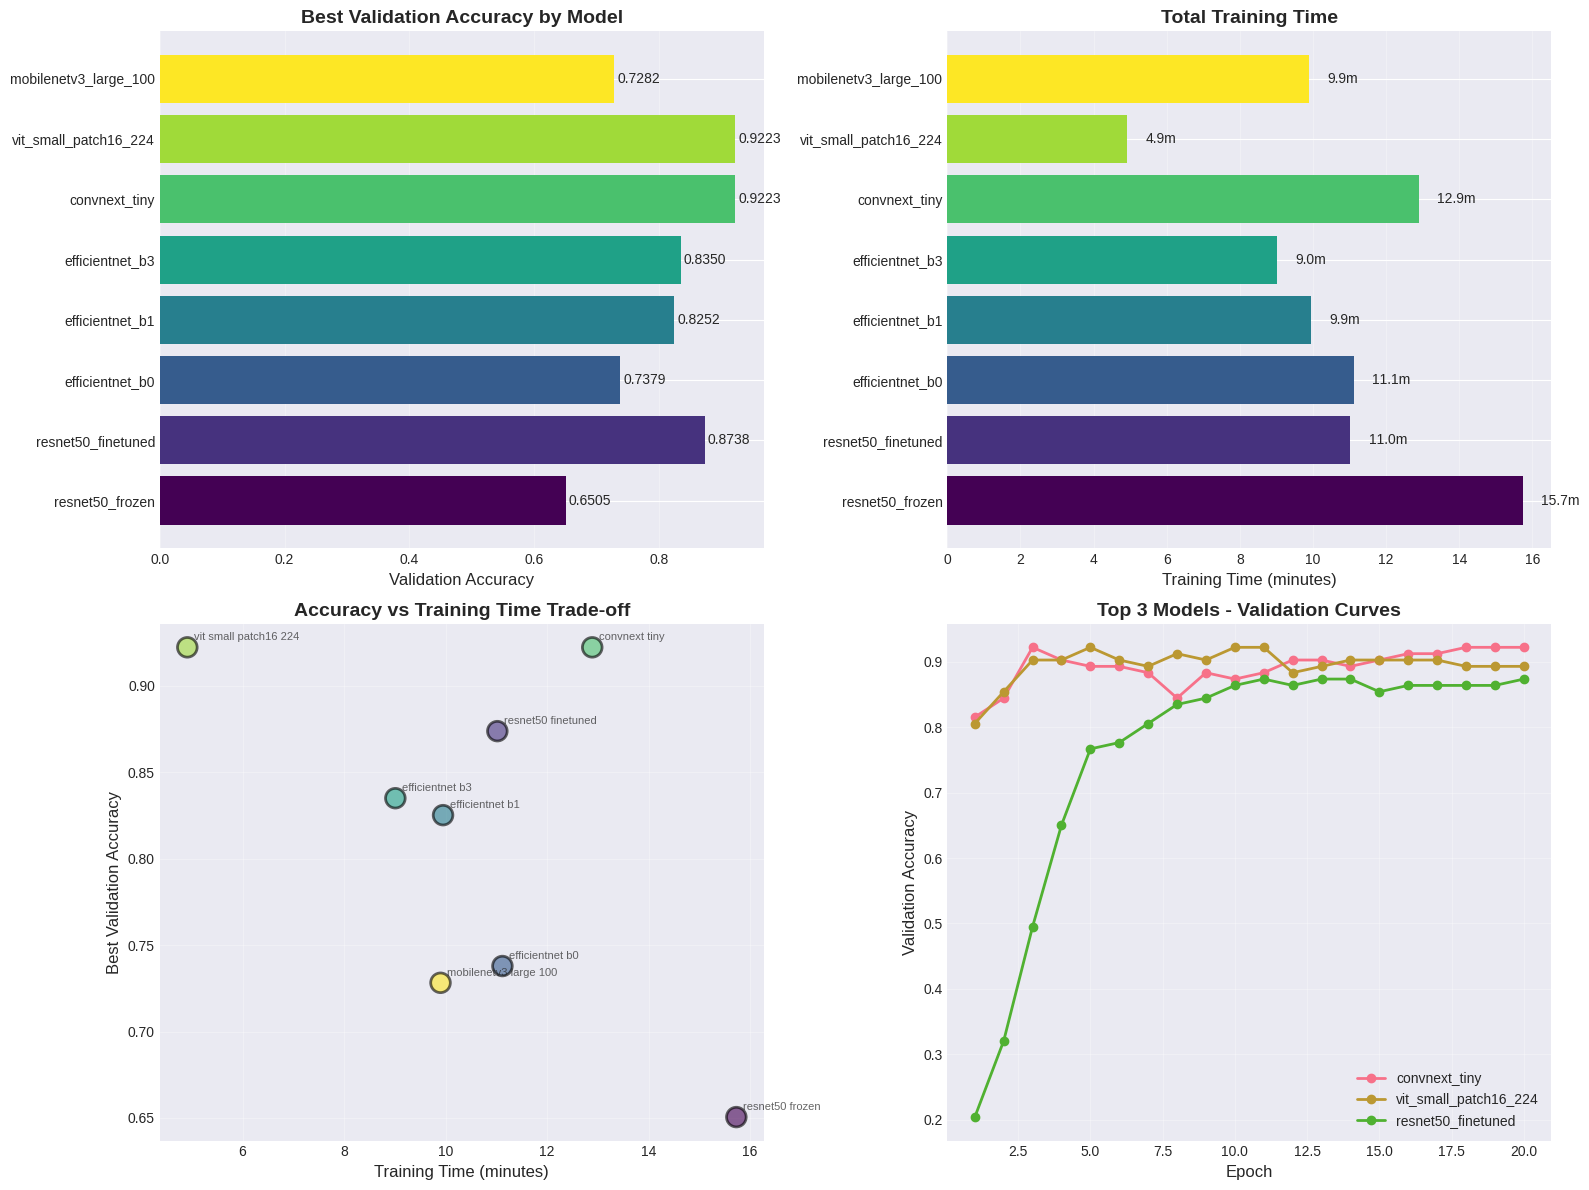

✓ Comparison plots saved


In [ ]:
# Plot comparison - Accuracy
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Best validation accuracy
model_names = [r['Model'] for r in comparison_data]
best_accs = [float(r['Best Val Acc']) for r in comparison_data]
colors = plt.cm.viridis(np.linspace(0, 1, len(model_names)))

axes[0, 0].barh(model_names, best_accs, color=colors)
axes[0, 0].set_xlabel('Validation Accuracy', fontsize=12)
axes[0, 0].set_title('Best Validation Accuracy by Model', fontsize=14, fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3)
for i, v in enumerate(best_accs):
    axes[0, 0].text(v + 0.005, i, f'{v:.4f}', va='center')

# Training time comparison
train_times = [float(r['Total Time (min)']) for r in comparison_data]
axes[0, 1].barh(model_names, train_times, color=colors)
axes[0, 1].set_xlabel('Training Time (minutes)', fontsize=12)
axes[0, 1].set_title('Total Training Time', fontsize=14, fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3)
for i, v in enumerate(train_times):
    axes[0, 1].text(v + 0.5, i, f'{v:.1f}m', va='center')

# Accuracy vs Time scatter
axes[1, 0].scatter(train_times, best_accs, s=200, c=range(len(model_names)),
                   cmap='viridis', alpha=0.6, edgecolors='black', linewidth=2)
for i, name in enumerate(model_names):
    axes[1, 0].annotate(name.replace('_', ' '),
                       (train_times[i], best_accs[i]),
                       xytext=(5, 5), textcoords='offset points',
                       fontsize=8, alpha=0.7)
axes[1, 0].set_xlabel('Training Time (minutes)', fontsize=12)
axes[1, 0].set_ylabel('Best Validation Accuracy', fontsize=12)
axes[1, 0].set_title('Accuracy vs Training Time Trade-off', fontsize=14, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Training curves for top 3 models
sorted_results = sorted(results.items(), key=lambda x: x[1]['best_val_acc'], reverse=True)
for i, (model_name, result) in enumerate(sorted_results[:3]):
    epochs_range = range(1, len(result['history']['val_acc']) + 1)
    axes[1, 1].plot(epochs_range, result['history']['val_acc'],
                    marker='o', label=model_name, linewidth=2)

axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Validation Accuracy', fontsize=12)
axes[1, 1].set_title('Top 3 Models - Validation Curves', fontsize=14, fontweight='bold')
axes[1, 1].legend(loc='lower right')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['results_dir'], 'phase1_comparison.png'),
            dpi=150, bbox_inches='tight')
plt.show()

print('✓ Comparison plots saved')

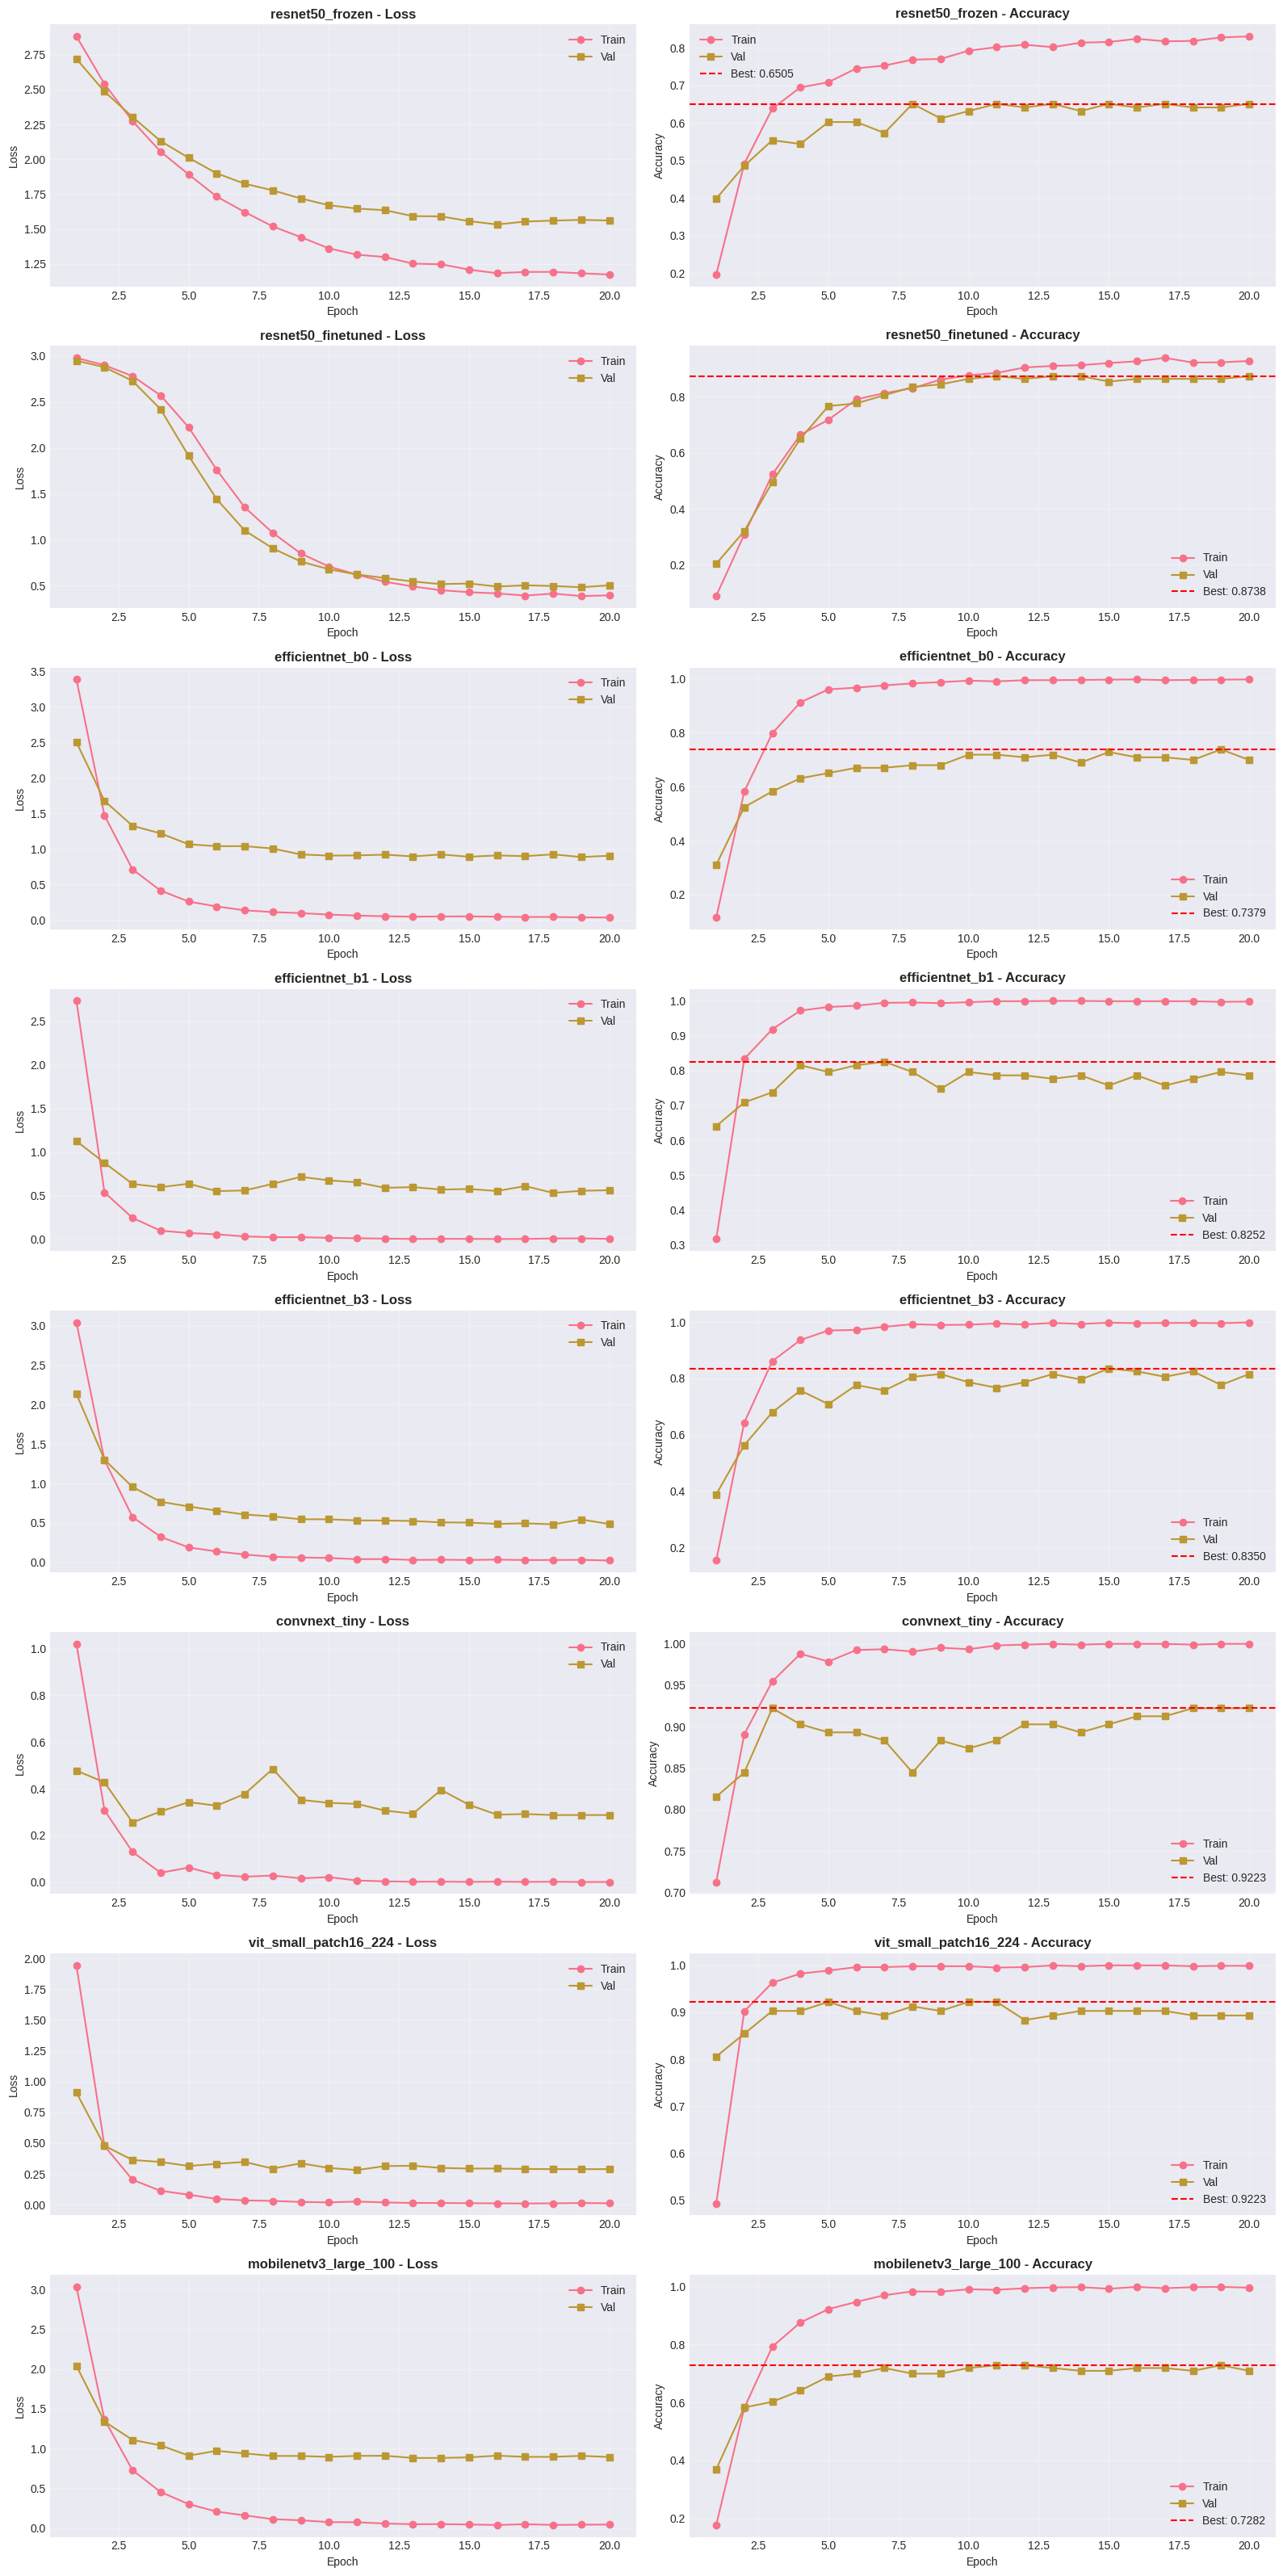

✓ Training curves saved


In [ ]:
# Detailed training curves for each model
n_models = len(results)
fig, axes = plt.subplots(n_models, 2, figsize=(16, 4 * n_models))

if n_models == 1:
    axes = axes.reshape(1, -1)

for idx, (model_name, result) in enumerate(results.items()):
    history = result['history']
    epochs_range = range(1, len(history['val_acc']) + 1)

    # Loss plot
    axes[idx, 0].plot(epochs_range, history['train_loss'], label='Train', marker='o')
    axes[idx, 0].plot(epochs_range, history['val_loss'], label='Val', marker='s')
    axes[idx, 0].set_xlabel('Epoch')
    axes[idx, 0].set_ylabel('Loss')
    axes[idx, 0].set_title(f'{model_name} - Loss', fontweight='bold')
    axes[idx, 0].legend()
    axes[idx, 0].grid(alpha=0.3)

    # Accuracy plot
    axes[idx, 1].plot(epochs_range, history['train_acc'], label='Train', marker='o')
    axes[idx, 1].plot(epochs_range, history['val_acc'], label='Val', marker='s')
    axes[idx, 1].axhline(result['best_val_acc'], color='red', linestyle='--',
                        label=f"Best: {result['best_val_acc']:.4f}")
    axes[idx, 1].set_xlabel('Epoch')
    axes[idx, 1].set_ylabel('Accuracy')
    axes[idx, 1].set_title(f'{model_name} - Accuracy', fontweight='bold')
    axes[idx, 1].legend()
    axes[idx, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['results_dir'], 'phase1_training_curves.png'),
            dpi=150, bbox_inches='tight')
plt.show()

print('✓ Training curves saved')

## 7. Generate Submission from Best Model

In [ ]:
# Load best model for inference
# best_model_name = max(results.items(), key=lambda x: x[1]['best_val_acc'])[0]
best_model_name='convnext_tiny'
best_config = [c for c in BASELINE_MODELS if c['name'] == best_model_name][0]

print(f"Loading best model: {best_model_name}")

# Create model
model = create_model(
    best_config['model_type'],
    num_classes=NUM_CLASSES,
    pretrained=False,  # Load trained weights
    freeze_backbone=False
)

# Load checkpoint
checkpoint_path = os.path.join(CONFIG['checkpoint_dir'], f'{best_model_name}_best.pth')
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

print(f"✓ Model loaded (Val Acc: {checkpoint['val_acc']:.4f})")

Loading best model: convnext_tiny
✓ Model loaded (Val Acc: 0.9223)


In [ ]:
# Inference & Submission
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

class TestBirdDataset(Dataset):
    def __init__(self, test_dir, transforms=None):
        self.image_paths = []
        self.transforms = transforms

        print(f"Scanning test images in: {test_dir}")
        for root, dirs, files in os.walk(test_dir):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(root, file))

        print(f"Found {len(self.image_paths)} test images")
        if len(self.image_paths) == 0:
            raise ValueError(f"No images found in {test_dir}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert("RGB")
            image = np.array(image)  # Convert to numpy for Albumentations
        except Exception as e:
            print(f"Warning: Failed to load {img_path}, using blank image")
            image = np.full((CONFIG['img_size'], CONFIG['img_size'], 3), 128, dtype=np.uint8)

        if self.transforms:
            transformed = self.transforms(image=image)
            image = transformed['image']

        return image, img_path

# Generate submission function
def generate_submission():
    model.eval()

    val_transforms = get_transforms(CONFIG['img_size'], 'val')
    test_dataset = TestBirdDataset(CONFIG['test_images'], transforms=val_transforms)

    test_loader = DataLoader(
        test_dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )

    predictions = []
    all_paths = []

    print("Generating predictions...")
    with torch.no_grad():
        for images, paths in tqdm(test_loader, desc='Test Inference'):
            images = images.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)  # Matches your original code
            predictions.extend(preds.cpu().numpy())
            all_paths.extend(paths)

    submission = pd.DataFrame({
        'path': [os.path.basename(p) for p in all_paths],
        'class_idx': predictions
    })

    submission_path = os.path.join(CONFIG['results_dir'], f'submission_phase1_{best_model_name}.csv')
    submission.to_csv(submission_path, index=False)

    print(f"\n✓ Submission saved: {submission_path}")
    print(f"Total predictions: {len(predictions)}")
    print("\nPrediction distribution:")
    print(pd.Series(predictions).value_counts().sort_index())

    return submission

# Run inference
submission = generate_submission()
print(submission.head())


Scanning test images in: /content/drive/MyDrive/data/test_images
Found 400 test images
Generating predictions...


Test Inference:   0%|          | 0/13 [00:00<?, ?it/s]


✓ Submission saved: /content/drive/My Drive/ml_results/phase1_results/submission_phase1_convnext_tiny.csv
Total predictions: 400

Prediction distribution:
0     26
1     13
2     24
3     16
4     26
5     20
6     16
7     24
8     20
9     25
10    17
11    16
12    15
13    17
14    22
15    16
16    21
17    26
18    20
19    20
Name: count, dtype: int64
                                       path  class_idx
0  501cf977-75b0-4ea4-98ee-308226718320.jpg          9
1  2976d7c8-2f82-4c86-a04e-68327dab64cf.jpg          8
2  a4c63f83-0d36-4a0d-80d5-27193a6103cf.jpg         16
3  808b7241-b19a-4323-8d34-1ea530be696e.jpg          5
4  d5a60446-0497-4ba0-bcfd-eb664ed824e2.jpg          2
